# Running Decision Tree Model

In [ ]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

In [3]:
import os
import pandas as pd
import math 
from collections import defaultdict 
import matplotlib.pyplot as plt

DATA_DIR="../data"

In [4]:
# Get the list of files in the directory
files = os.listdir(DATA_DIR)

# Print the list of files
for file in files:
    print(file)

super_families_indices.pickle
archid_encoded_features_dict.pickle
Title_Strings.csv
.DS_Store
CD_models_all
CD_models_curated_sorted
archid_encoded_curname_dict.pickle
SPARCLE_IDS_curated.mtx4ml.tsv.gz
input_output_list.pickle
curated_names_unique
CD_models_curated
SPARCLE_IDS_UNcurated_TITLES.csv.gz
SPARCLE_IDS_curated_simplified_modTitleStrings.csv
SPARCLE_IDS_all_current.csv.gz
super_families_curated
SPARCLE_IDS_curated.csv
CD_models_indices.pickle
SPARCLE_IDS_curated_simplified.mtx4ml.tsv.gz
SPARCLE_IDS_UNcurated.csv
simplified_Curname_set.csv
Title_Strings_sorted_uniq
cd_id_nme_shortnme.csv
SPARCLE_IDS_curated_simplified.csv
super_families_curated_sorted


## Import preprocessed data

### Import input - SPARCLE_IDS_curated_simplified.mtx4ml.tsv.gz

In [25]:
# Access &read the file 
file_path = os.path.join(DATA_DIR, "SPARCLE_IDS_curated_simplified.mtx4ml.tsv.gz")
df_one_hot = pd.read_csv(file_path, sep='\t', compression='gzip')

#test succ. loading
df_one_hot.head()

,CurName_simplified,SpecificArch_CHL00001,SpecificArch_CHL00002,SpecificArch_CHL00004,SpecificArch_CHL00005,SpecificArch_CHL00008,SpecificArch_CHL00009,SpecificArch_CHL00011,SpecificArch_CHL00012,SpecificArch_CHL00013,...,superfamilyarch_zinc_ribbon_2 PKc_like,superfamilyarch_zinc_ribbon_2 PTC1,superfamilyarch_zinc_ribbon_2 UPF0182,superfamilyarch_zinc_ribbon_4,superfamilyarch_zinc_ribbon_4 PqiA,superfamilyarch_zinc_ribbon_5 PqiA,superfamilyarch_zinc_ribbon_9 RING_Ubox,superfamilyarch_zntA,superfamilyarch_znuC,superfamilyarch_zwf
0,"(2,3-dihydroxybenzoyl)adenylate synthase",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"(2,3-dihydroxybenzoyl)adenylate synthase",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"(2,3-dihydroxybenzoyl)adenylate synthase",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"(2E,6E)-farnesyl diphosphate synthase",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,(2Fe-2S) ferredoxin domain-containing protein,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
df_one_hot.shape

(38167, 48297)

In [27]:
columns_to_drop = [col for col in df_one_hot.columns if col.startswith("SpecificArch")]
df_one_hot_superFamOnly = df_one_hot.drop(columns=columns_to_drop)

In [28]:
df_one_hot_superFamOnly.shape

(38167, 20243)

### Import input - indices.pickle

In [5]:
import pickle

In [16]:
with open(os.path.join(DATA_DIR, 'input_output_list.pickle'), 'rb') as f:
    a = pickle.load(f)

In [24]:
pd.DataFrame(a[0]), pd.DataFrame(a[1])

(   0     1     2    3    4     5    6    7    8    9    ...  440  441  442  \
 0    0     0     0    0    0     0    0    0    0    0  ... -1.0 -1.0 -1.0   
 1  135  5118  4211  130   56  2276   20   -1   -1   -1  ...  NaN  NaN  NaN   
 
    443  444  445  446  447  448  449  
 0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
 1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
 
 [2 rows x 450 columns],
    0     1     2    3    4     5    6    7    8    9    ...  440  441  442  \
 0    0     0     0    0    0     0    0    0    0    0  ... -1.0 -1.0 -1.0   
 1  135  5118  4211  130   56  2276   20   -1   -1   -1  ...  NaN  NaN  NaN   
 
    443  444  445  446  447  448  449  
 0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  
 1  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
 
 [2 rows x 450 columns])

## Data Filtering 

Remove all columns that have less than <i>threshold</i> occurances in total. Then remove those data points that do not have any 

In [65]:
df_one_hot_filtered = df_one_hot_superFamOnly
threshold = 1
exclude_column = ['CurName_simplified']
remaining_columns = df_one_hot_filtered.columns.difference(exclude_column)

In [66]:
counts = (df_one_hot_filtered[remaining_columns] == 1).sum()

Frequency table

In [67]:
frequency_table = counts.value_counts().sort_index()
frequency_table

1      14296
2       3100
3       1041
4        542
5        315
       ...  
197        1
226        1
297        1
369        1
382        1
Name: count, Length: 83, dtype: int64

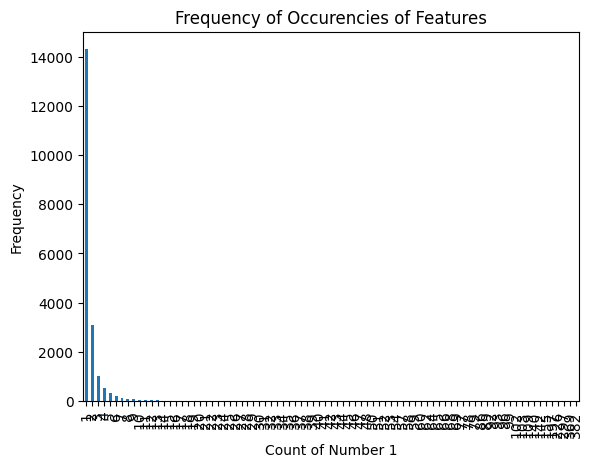

In [68]:
frequency_table.plot(kind='bar')

# Adding titles and labels
plt.title('Frequency of Occurencies of Features')
plt.xlabel('Count of Number 1')
plt.ylabel('Frequency')

# Displaying the plot
plt.show()

In [9]:
# Filter out columns where the count is less than the threshold
columns_to_drop = counts[counts < threshold].index

In [10]:
# Drop the columns from the DataFrame
df_one_hot_filtered.drop(columns=columns_to_drop, inplace=True)

In [11]:
df_one_hot_filtered.shape

(38167, 2322)

In [12]:
# Keep rows where any column equals 1
df_filtered = df_one_hot_filtered[df_one_hot_filtered.apply(lambda row: (row == 1).any(), axis=1)]

In [13]:
df_filtered.shape

(22486, 2322)

## Fuzzy Matching to evaluate results

Imported and modified from fuzzy_match_CurName.ipynb (CM)

In [43]:
import sys, os, json
import fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import pandas as pd
from pathlib import Path
import Levenshtein

In [42]:
# Define a threshold for considering a prediction as correct
similarity_threshold = 80

def calculate_similarity_scores(predictions, actuals, threshold=similarity_threshold):
    correct_predictions = 0
    total_predictions = len(predictions)
    
    # Scores for different types of comparisons
    similarity_scores = []
    partial_scores = []
    token_sort_scores = []
    token_set_scores = []
    
    for predicted, actual in zip(predictions, actuals):
        # Convert to lower case for case-insensitive comparison
        predicted_lower = predicted.lower()
        actual_lower = actual.lower()
        
        # Calculate similarity score and other types of scores
        similarity = fuzz.ratio(predicted_lower, actual_lower)
        partial = fuzz.partial_ratio(predicted_lower, actual_lower)
        token_sort = fuzz.token_sort_ratio(predicted_lower, actual_lower)
        token_set = fuzz.token_set_ratio(predicted_lower, actual_lower)
        
        # Record the scores
        similarity_scores.append(similarity)
        partial_scores.append(partial)
        token_sort_scores.append(token_sort)
        token_set_scores.append(token_set)
        
        # Check if the similarity score is above the threshold
        if similarity >= threshold:
            correct_predictions += 1
    
    # Calculate adjusted accuracy
    adjusted_accuracy = correct_predictions / total_predictions
    
    return adjusted_accuracy, similarity_scores, partial_scores, token_sort_scores, token_set_scores

## Split data set into training and testing data

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
#just for test and short running of problem: take first 1000 lines from df
df_final = df_one_hot_superFamOnly#.head(5000)

In [31]:
X = df_final.drop(['CurName_simplified'], axis=1)  # Features
y = df_final['CurName_simplified']  # Target variable

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (28625, 20242)
Testing set size: (9542, 20242)


In [33]:
#test access
X_train.iloc[[29]]
y_train.iloc[[29]]

3096    APC family permease
Name: CurName_simplified, dtype: object

## Decision Tree Classifier

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [35]:
# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

In [36]:
# Fit the model on the training data
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [37]:
# Make predictions and evaluate the model
predictions = clf.predict(X_test)

In [38]:
# Evaluate the model (e.g.: accuracy)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)

print("Accuracy:", accuracy)

Accuracy: 0.39834416264933975


### Prediction results

#### One_hot_encoding with SuperFamily Only 

In [39]:
#75% training, 25% testing, SuperFamily Only!
# Evaluate the model (e.g.: accuracy)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)

print("Accuracy:", accuracy)

comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions, 'Equal': predictions==y_test}).sort_values(by='Equal')
print(len(comparison_df), len(comparison_df[comparison_df["Equal"] == True]))
comparison_df.head(25)

Accuracy: 0.39834416264933975
9542 3801


,Actual,Predicted,Equal
7294,CPBP family intramembrane glutamic endopeptidase,lysostaphin resistance A-like protein,False
11361,DUF4059 family protein,MFS transporter,False
27603,radical SAM protein,MFS transporter,False
1794,acyltransferase family protein,ACP S-malonyltransferase,False
8671,dihydroorotase,amidohydrolase,False
24411,p-aminobenzoyl-glutamate transporter,anaerobic C4-dicarboxylate transporter,False
22878,NAD-dependent DNA ligase LigB,ATP-dependent DNA ligase,False
32867,TatD family hydrolase,MFS transporter,False
5508,cadherin repeat domain-containing protein,MFS transporter,False
36900,xanthine dehydrogenase FAD-binding subunit XdhB,MFS transporter,False


In [40]:
print(comparison_df['Predicted'].value_counts())
print(y_train.value_counts())

Predicted
MFS transporter                                                                                       3523
serine/threonine-protein kinase                                                                        109
SDR family oxidoreductase                                                                              103
RNA-binding protein                                                                                     96
hybrid sensor histidine kinase/response regulator                                                       74
                                                                                                      ... 
DUF2332 domain-containing protein                                                                        1
methane monooxygenase/ammonia monooxygenase subunit                                                      1
YuzD family protein                                                                                      1
YibE/F family protein      

In [41]:
print(clf.tree_.node_count)
print(clf.get_n_leaves())
print(clf.get_depth())

30273
15137
14032


In [53]:
# Calculate scores and adjusted accuracy
adjusted_accuracy, similarity_scores, partial_scores, token_sort_scores, token_set_scores = calculate_similarity_scores(predictions, y_test)

print(f"Adjusted Accuracy: {adjusted_accuracy*100:.2f}%")
print(sum(similarity_scores)/len(similarity_scores))
print(sum(partial_scores)/len(partial_scores))
print(sum(token_sort_scores)/len(token_sort_scores))
print(sum(token_set_scores)/len(token_set_scores))

#print("Token Set Scores:", token_set_scores)
#print("Similarity Scores:", similarity_scores)
#print("Partial Match Scores:", partial_scores)
#print("Token Sort Scores:", token_sort_scores)
#print("Token Set Scores:", token_set_scores)

Adjusted Accuracy: 43.45%
65.50890798574723
71.0051351917837
65.04820792286732
67.69052609515825


#### Too small training set, One hot encoded specArch and super fam

In [42]:
#25% training
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions, 'Equal': predictions==y_test}).sort_values(by='Equal')
print(len(comparison_df), len(comparison_df[comparison_df["Equal"] == True]))
comparison_df.head(15)

28626 8033


,Actual,Predicted,Equal
26528,prefoldin subunit alpha,prefoldin subunit,False
11399,DUF4125 family protein,transposase,False
6061,CDK5RAP3 family protein,transposase,False
12685,electron transfer flavoprotein subunit,transposase,False
33432,thiosulfate reductase PhsA,transposase,False
17461,Homer/Vesl family protein,Homer protein homolog,False
26130,pol protein pepsin-like aspartate protease and...,pol protein,False
14410,flagellin,transposase,False
15105,gelsolin-like protein,gelsolin/scinderin family protein,False
16747,HAMP domain-containing histidine kinase,sensor histidine kinase,False


In [62]:
print(comparison_df['Predicted'].value_counts())
print('\nLabel "transposase" in training: ', len(y_train[y_train=='transposase']))

Predicted
transposase                                                 13076
SDR family oxidoreductase                                     327
serine/threonine-protein kinase                               306
RNA-binding protein                                           289
hybrid sensor histidine kinase/response regulator             275
                                                            ...  
lipase family protein                                           1
EAL domain-containing response regulator                        1
retropepsin-like aspartic protease/reverse transcriptase        1
terpene synthase family protein                                 1
hypermethylated in cancer protein                               1
Name: count, Length: 1127, dtype: int64

Label "transposase" in training:  58


In [78]:
print(clf.tree_.node_count)
print(clf.get_n_leaves())
print(clf.get_depth())

4063
2032
1329


## Support Vector Machine (SVM)

In [85]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd

In [86]:
# Initialize the SVM classifier
svm_clf = SVC(random_state=42)

In [ ]:
# Fit the model on the training data
svm_clf.fit(X_train, y_train)

In [ ]:
# Make predictions on the test set
predictions = svm_clf.predict(X_test[1])

In [72]:
# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
accuracy

0.032

In [ ]:
# Define the parameter grid for SVC
param_grid = {
    'C': [0.1, 1, 10],  # Example parameter: Regularization strength
    'kernel': ['linear', 'rbf'],  # Example parameter: Type of SVM kernel
    # Add other parameters here if needed
}

In [ ]:
# Set n_jobs=-1 to use all available CPUs for parallelizing the search
grid_search = GridSearchCV(SVC(random_state=42), param_grid, n_jobs=-1, verbose=1)


In [ ]:
grid_search.fit(X_train, y_train_encoded)

In [ ]:
best_svc = grid_search.best_estimator_

In [ ]:
predictions = best_svc.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test_encoded, predictions)

In [ ]:
print("Best SVC Parameters:", grid_search.best_params_)
print("SVM Accuracy with Best Parameters:", accuracy)

## Principal Component Analysis

In [73]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [74]:
# standardize features before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [78]:
# Initialize PCA - for example, to reduce the dataset to 2 principal components
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [ ]:
# The number of components PCA chose to keep
print("Number of components chosen:", pca.n_components_)

In [ ]:
#now re-run PCA or SVM with reduced dimensions!